# **Unsupervised Learning: What is a Sports Car?**

Jürg Schelldorfer, with support from Michael Mayer, Daniel Meier and [Mirai Solutions GmbH](https://mirai-solutions.ch/), based on the code from Simon Rentzmann and Mario Wüthrich.

2021-04-30

# Table of contents
1. [Introduction](#intro) 
2. [Data Preparation](#dataPrep)             
      2.1 [Load package](#pkg)             
      2.2 [Set global parameters](#paramSeed)             
      2.3 [Helper functions](#helpers)             
      2.4 [Load data](#loadData)                   
      2.5 [Inspect the raw dataset](#inspectData)
3. [Data preprocessing and visualizations](#processing)                       
    3.1 [Derive Gaussian-distributed variables](#deriveGauss)                          
    3.2 [Define sports car using car experts knowledge](#sportsCar)                       
    3.3 [Define covariates for analysis](#covariates)                                              
4. [Dimension reduction](#dim)                            
    4.1 [Principal Component Analysis (PCA)](#pca)                
    4.2 [Bottleneck neural network (BNN)](#bnn)                     
5. [Clustering](#clustering)                             
    5.1 [Introduction](#introClustering)                  
    5.2 [k-means cluster](#kmeans)                
    5.3 [k-medoids clustering](#kmedoids)                     
    5.4 [Gaussian mixture models (GMM)](#gmm)                    
6. [Low dimensional visualizations](#vis)                                        
    6.1 [Introduction](#introLdv)                              
    6.2 [t-distributed stochastic neighboring embedding (t-SNE)](#tsne)                                     
    6.3 [Uniform manifold approximation and projection (UMAP)](#umap)                   
    6.4 [Self-organizing map and Kohonen map (SOM)](#som)                            
7. [Remarks](#rmk)
8. [Session Info](#session)

# 1. Introduction<a name="intro"></a>

This notebook serves as accompanion to the tutorial “Unsupervised Learning: What is a Sports Car?”, available on [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3439358).

The code is similar to the code used in above tutorial and combines the raw R code in the scripts, available on [GitHub](https://github.com/JSchelldorfer/ActuarialDataScience/tree/master/5%20-%20Unsupervised%20Learning%20What%20is%20a%20Sports%20Car) along with some more comments. Please refer to the tutorial for explanations.

Note that the results might vary depending on the R and Python package versions, see last section for the result of sessionInfo() and corresponding info on the Python setup.

The following figure gives a schematic overview of the structure of this tutorial.

![usl](Figure1_USL.PNG)

# 2. Data Preparation<a name="dataPrep"></a>

The tutorial uses amended data from the article "What is a sports car" by Ingenbleek-Lemaire. Unfortunately, only part of the original data set is still available. For the tutorial, we have extended this original part of the data with additional cars which have been compiled from the internet. The data is available on [github](https://github.com/JSchelldorfer/ActuarialDataScience/tree/master/5%20-%20Unsupervised%20Learning%20What%20is%20a%20Sports%20Car).

## 2.1 Load packages<a name="pkg"></a>

In [209]:
library(tidyverse)
library(plotrix)
library(matrixStats)
library(cluster)
library(ClusterR)
library(tsne)
library(umap)
library(kohonen)
library(MASS)
library(keras)
library(GGally)
library(gridExtra)
library(reticulate)

## 2.2 Set global parameters<a name="paramSeed"></a>

In [210]:
options(encoding = 'UTF-8')

In [211]:
# Global parameters
seed <- 100 # seed
axis_limit <- 7 # min/max for clustering

In [212]:
# set seed to obtain best reproducibility. note that the underlying architecture may affect results nonetheless, so full reproducibility cannot be guaranteed across different platforms.
Sys.setenv(PYTHONHASHSEED = seed)
set.seed(seed)
reticulate::py_set_seed(seed)
tensorflow::tf$random$set_seed(seed)

## 2.3 Helper functions<a name="helpers"></a>

Subsequently, for ease of reading, we provide all the helper functions which are used in this tutorial in this section.

In [213]:
## FrobeniusLoss(...)
FrobeniusLoss <- function(X1, X2) {
  sqrt(sum(as.matrix((X1 - X2) ^ 2)) / nrow(X1))
}

In [215]:
## BottleneckThreeLayer(...)
## bottleneck three layers

BottleneckThreeLayer <- function(q00, q11, q22) {
  Input <-layer_input(shape = c(q00),
                      dtype = 'float32',
                      name = 'Input')
  
  Encoder <- Input %>%
    layer_dense(units = q11,
                activation = 'tanh',
                use_bias = FALSE,
                name = 'Layer1'
    ) %>%
    layer_dense(units = q22,
                activation = 'tanh',
                use_bias = FALSE,
                name = 'Bottleneck'
    )
  
  Decoder <- Encoder %>%
    layer_dense(units = q11,
                activation = 'tanh',
                use_bias = FALSE,
                name = 'Layer3'
    ) %>%
    layer_dense(units = q00,
            activation = 'linear',
                use_bias = FALSE,
                name = 'Output'
    )
  
  model <- keras_model(inputs = Input, outputs = Decoder)
  
  model %>% compile(optimizer = optimizer_nadam(), loss = 'mean_squared_error')
  
  model
}

# 2.4 Load data<a name="loadData"></a>

In [216]:
sportsCar <- read.csv(file = "SportsCars.csv", sep = ";", header = TRUE)

# 2.5 Inspect the raw dataset<a name="inspectData"></a>

The data comprises the brand, type and model of the cars. For each car we have information about the cubic capacity (in cm3), the maximal power of engine (in kW), the maximal torque (in Nm), the number of seats, the weight of the car (in kg), the maximum engine speed (in rpm), the acceleration from 0 to 100km/h (in seconds), and the top speed (in km/h). The column tau will be explained later.

In [217]:
str(sportsCar)

'data.frame':	475 obs. of  13 variables:
 $ brand           : chr  "Austin" "Citroen" "Citroen" "Fiat" ...
 $ type            : chr  "Rovermini" "Visa" "2CV" "Panda" ...
 $ model           : chr  "Ehlemayair" "Baseclub" "Specialton" "34" ...
 $ cubic_capacity  : int  998 652 602 850 1598 845 956 1588 1596 992 ...
 $ max_power       : int  31 25 21 25 41 21 31 40 40 37 ...
 $ max_torque      : num  67 49 39 60 96 56 65 100 100 98 ...
 $ seats           : int  4 5 4 5 5 4 5 5 5 5 ...
 $ weight          : int  620 755 585 680 1015 695 695 900 1030 920 ...
 $ max_engine_speed: int  5000 5500 5750 5250 4600 4500 5750 4500 4800 4250 ...
 $ seconds_to_100  : num  19.5 26.2 NA 32.3 21 NA 19.3 18.7 20 NA ...
 $ top_speed       : int  129 125 115 125 143 115 137 148 140 130 ...
 $ sports_car      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ tau             : num  23.3 34.1 28.6 32.8 35 ...


In [218]:
head(sportsCar)

,brand,type,model,cubic_capacity,max_power,max_torque,seats,weight,max_engine_speed,seconds_to_100,top_speed,sports_car,tau
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
1,Austin,Rovermini,Ehlemayair,998,31,67,4,620,5000,19.5,129,0,23.33892
2,Citroen,Visa,Baseclub,652,25,49,5,755,5500,26.2,125,0,34.13032
3,Citroen,2CV,Specialton,602,21,39,4,585,5750,NA,115,0,28.64863
4,Fiat,Panda,34,850,25,60,5,680,5250,32.3,125,0,32.84696
5,Opel,Ascona2,LS1.6D,1598,41,96,5,1015,4600,21.0,143,0,35.00643
6,Renault,R4,Berlinetl,845,21,56,4,695,4500,NA,115,0,37.04656


In [219]:
summary(sportsCar)

    brand               type              model           cubic_capacity
 Length:475         Length:475         Length:475         Min.   : 602  
 Class :character   Class :character   Class :character   1st Qu.:1456  
 Mode  :character   Mode  :character   Mode  :character   Median :1796  
                                                          Mean   :1954  
                                                          3rd Qu.:2226  
                                                          Max.   :5763  
                                                                        
   max_power        max_torque        seats           weight    
 Min.   : 21.00   Min.   : 39.0   Min.   :2.000   Min.   : 585  
 1st Qu.: 54.00   1st Qu.:109.0   1st Qu.:5.000   1st Qu.: 885  
 Median : 74.00   Median :153.0   Median :5.000   Median :1065  
 Mean   : 79.76   Mean   :163.9   Mean   :4.794   Mean   :1092  
 3rd Qu.: 97.00   3rd Qu.:189.0   3rd Qu.:5.000   3rd Qu.:1266  
 Max.   :335.00   Max.   :

# 3. Data preprocessing and visualizations<a name="processing"></a>

## 3.1 Derive Gaussian-distributed variables<a name="deriveGauss"></a>

We consider the logarithmized data of the weight, the maximal power, the cubic capacity, the maximal torque,
the maximal engine speed, the seconds to 100km/h and the top speed of the cars.

In [220]:
# change to log scale
sportsCar <- sportsCar %>% mutate(W_l = log(weight),
                        MP_l = log(max_power),
                        CC_l = log(cubic_capacity),
                        MT_l = log(max_torque),
                        MES_l = log(max_engine_speed),
                        S100_l = log(seconds_to_100),
                        TS_l = log(top_speed))

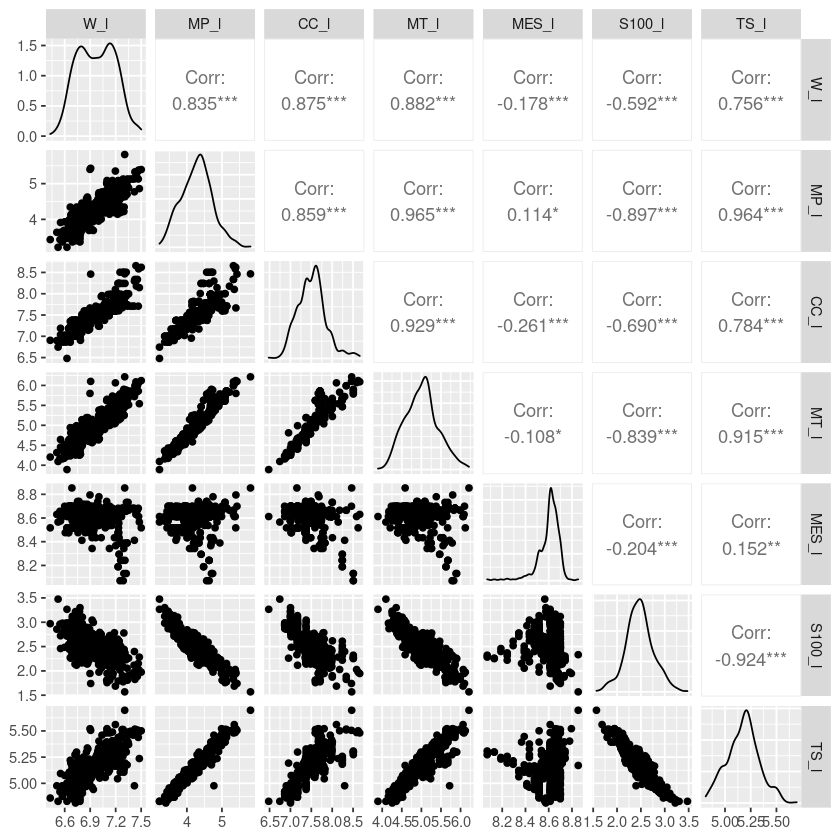

In [221]:
ggpairs(sportsCar %>% filter(!is.na(S100_l)), columns = 14:20)

We observe that these variables look fairly Gaussian on the log-scale, only the maximal engine speed MES_l seems to be more skewed.

## 3.2 Define sports car using car experts knowledge<a name="sportsCar"></a>

The data was used in the 1970s in Belgium to discriminate sports cars from ordinary cars. A formula had been derived by car experts, based on the variables and the value of $\tau$. See the tutorial for the corresponding formulas.

According to this formula, a car is defined to be a sports car iff $\tau$ < 17.

In [222]:
# type of cars
sportsCar <- sportsCar %>% mutate(sports_type = cut(tau,
                                   breaks = c(0, 17, 21, 100),
                                   labels = c("tau<17 (sports car)", 
                                              "17<=tau<21", "tau>=21")))

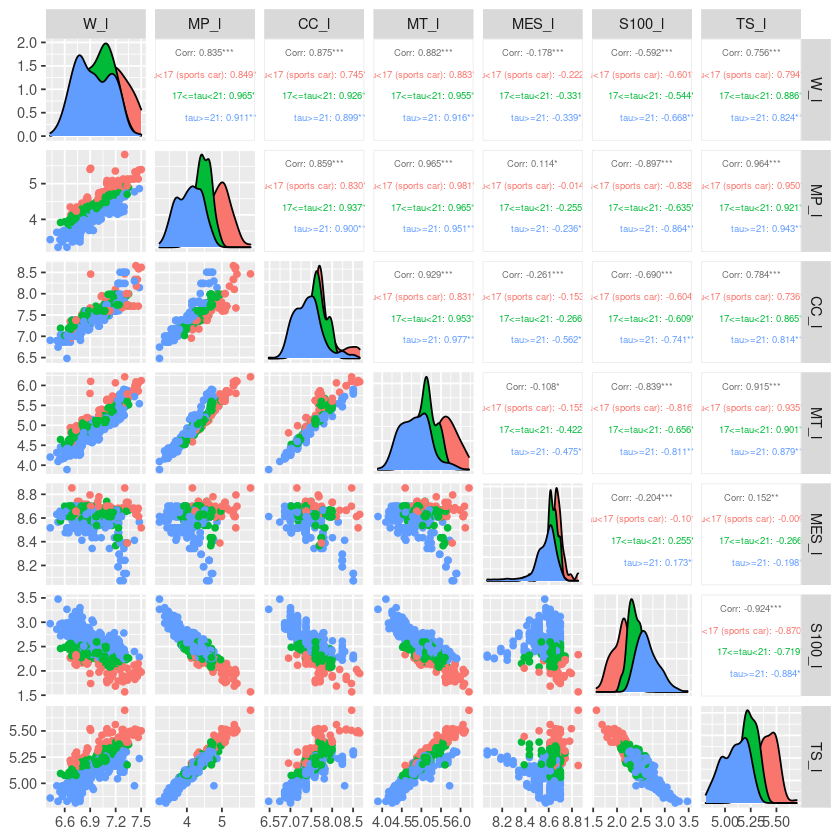

In [223]:
ggpairs(data = sportsCar %>% filter(!is.na(S100_l)), columns = 14:20, mapping = aes(colour = sports_type), 
        upper = list(continuous = wrap("cor", size = 2)))

## 3.3 Define covariates for analysis<a name="covariates"></a>

The goal of Ingenbleek-Lemaire has been to improve this expert choice using principal components analysis (PCA). First, Ingenbleek-Lemaire defined the following features (covariates).

In [224]:
## direct computation
sportsCar <- sportsCar %>% mutate(x1 = log(weight / max_power),
                        x2 = log(max_power / cubic_capacity),
                        x3 = log(max_torque),
                        x4 = log(max_engine_speed),
                        x5 = log(cubic_capacity)
)

These new features are illustrated below.

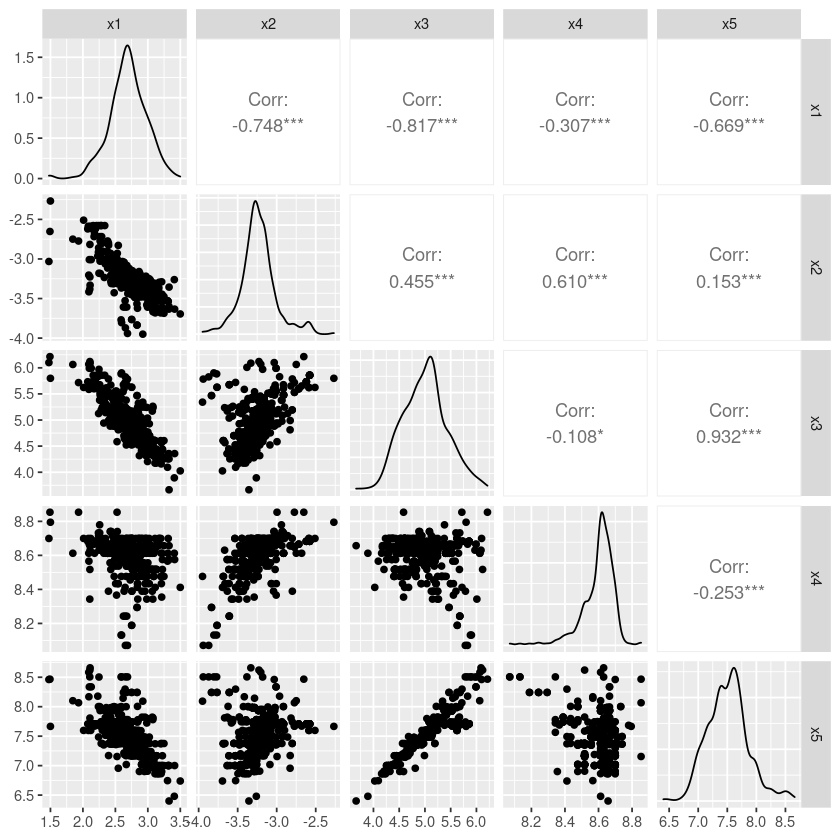

In [225]:
ggpairs(sportsCar[, c("sports_type", "x1", "x2", "x3", "x4", "x5")], columns = 2:6)

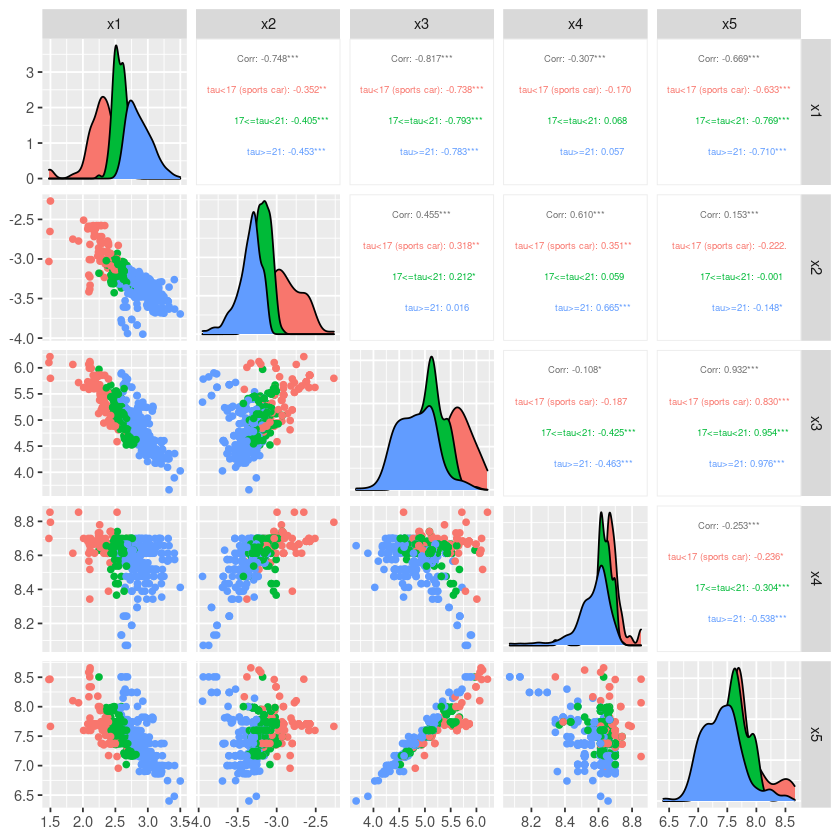

In [226]:
ggpairs(data = sportsCar[, c("sports_type", "x1", "x2", "x3", "x4", "x5")], columns = 2:6, mapping = aes(colour = sports_type),
  upper = list(continuous = wrap("cor", size = 2))
)

Below, we provide the empirical marginal densities of the features $x_1,...,x_5$ over all available cars and we compare it to a Gaussian approximation. For components $x_1$, $x_2$, $x_3$, $x_5$, the Gaussian approximation works reasonably well, for component $x_4$, log(max_engine_speed), the Gaussian approximation does not look reasonable.

We are mentioning this because in most subsequent analysis we are using the (squared) Euclidean distance in the objective function, which is the canonical choice for (multivariate) Gaussian random variables (vectors). Moreover, for studying multivariate Gaussian distributions we should have Gaussian copulas (dependence structure) which is not fully justified by the scatter plots in the lower left triangle the above figures, because not all of these scatter plots have an elliptic shape.

In [227]:
# data frame with only the covariates
dat <- sportsCar %>% dplyr::select(c(x1, x2, x3, x4, x5))

In [228]:
# empirical density plots
m0 <- colMeans(dat)
X01 <- dat - colMeans(dat)[col(dat)]
sds <- sqrt(colMeans(X01 ^ 2)) * sqrt(nrow(dat) / (nrow(dat) - 1))

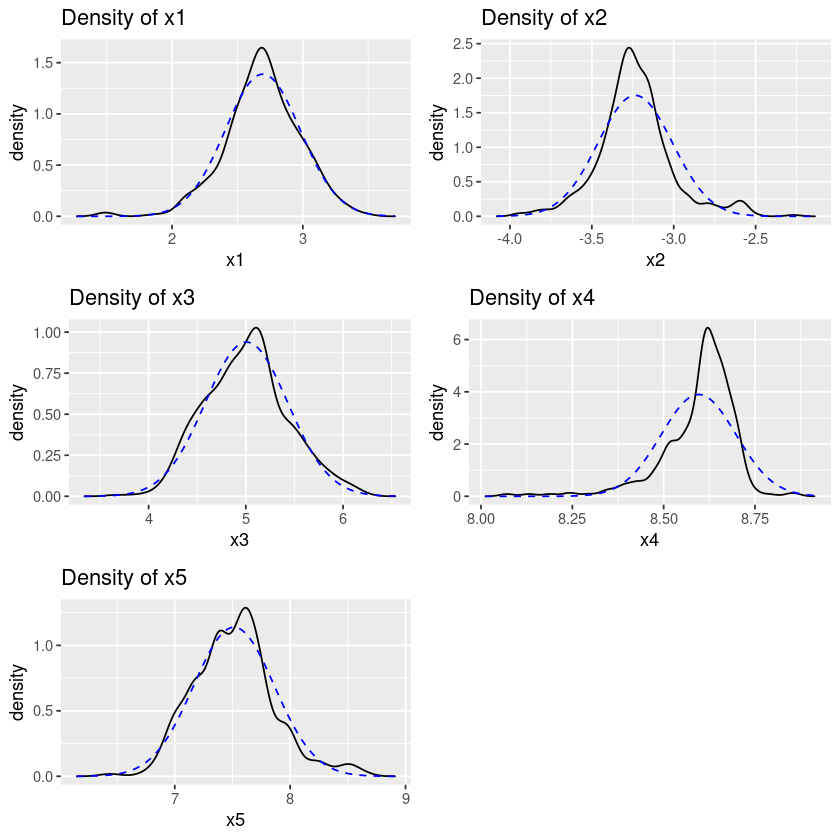

In [229]:
# black: empirical density, blue: Gaussian approximation
plot_density_for_var <- function(i) {
  dat_norm <- data.frame(x = density(dat[, i])$x,
                       y = dnorm(density(dat[, i])$x,
                                 mean = m0[i], sd = sds[i]))
  p <- ggplot(data = dat, aes_string(x = paste("x", i, sep = ""))) +
    geom_density() +
    geom_line(data = dat_norm, aes(x = x, y = y), 
              color = "blue", linetype = "dashed") +
    labs(x = paste0("x", i, sep = ""), y = "density",
      title = paste0("Density of x", i, sep = ""))
  p
}

p1 <- plot_density_for_var(1)
p2 <- plot_density_for_var(2)
p3 <- plot_density_for_var(3)
p4 <- plot_density_for_var(4)
p5 <- plot_density_for_var(5)
grid.arrange(p1, p2, p3, p4, p5, ncol = 2)

In the sequel of this tutorial we are going to explain several dimension reduction techniques and clustering methods on this data over all available cars $i = 1,..., n = 475$.

# 4. Dimension reduction<a name="dim"></a>

## 4.1 Principal Component Analysis (PCA) <a name="pca"></a>

In a nutshell, a PCA aims at reducing the dimension of high dimensional data such that the
reconstruction error relative to the original data is minimized. If applied successfully, it reduces
the dimension of the feature space, and it is particularly useful for (actuarial) regression modeling
because it provides a small number of uncorrelated explanatory variables.

Typically, the columns of the raw design matrix $X$ live on different scales and they are correlated. Since all further derivations should not depend on translations and scales we standardize the raw design matrix.

In [230]:
# normalization of design matrix (using 1/n for sd, identical figures to slides)
X01 <- dat - colMeans(dat)[col(dat)]
X <- X01 / sqrt(colMeans(X01 ^ 2))[col(X01)]

In [231]:
# normalization of design matrix (using 1/(n-1) for sd, slightly different figures to slides)
# X <- scale(dat, center = T, scale = T)

### 4.1.1 PCA using `svd(...)` function

Let us calculate the singular value decomposition of the scaled matrix $X$.

In [232]:
# singular value decomposition using svd(...)
svdX <- svd(as.matrix(X))
str(svdX)

List of 3
 $ d: num [1:5] 37.53 28.07 11.48 6.48 2.12
 $ u: num [1:475, 1:5] -0.0781 -0.1116 -0.1211 -0.1044 -0.0724 ...
 $ v: num [1:5, 1:5] -0.558 0.412 0.539 0.126 0.461 ...


Save the first two coordinates of the principal components to the data set for plotting and visualizations.

In [233]:
# first two principal components
pca <- c(1, 2)
sportsCar$v1 <- as.matrix(X) %*% svdX$v[, pca[1]]
sportsCar$v2 <- as.matrix(X) %*% svdX$v[, pca[2]]

**Summarize PCA results**: The singular values $\lambda_p$ and the scaled eigenvalues $\lambda_p^2/n$ are presented. Additionally we show the contribution of every singular value to te overall variation.

In [234]:
term <- svdX$d ^ 2 / nrow(X)
pca_prt <- data.frame(
  p = 1:ncol(X),
  sng_values = round(svdX$d, 2),
  scl_sng_values = round(term, 3),
  prop_incr = round(term / sum(term), 2),
  cum_incr = round(cumsum(term / sum(term)), 2)
)
pca_prt

p,sng_values,scl_sng_values,prop_incr,cum_incr
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,37.53,2.966,0.59,0.59
2,28.07,1.659,0.33,0.92
3,11.48,0.277,0.06,0.98
4,6.48,0.088,0.02,1.00
5,2.12,0.009,0.00,1.00


**Summarize PCA results**: Display the first two eigenvectors (they are 5-dimensional):

In [235]:
rbind(svdX$v[, 1], svdX$v[, 2])

-0.5577027,0.4122188,0.5389689,0.1262176,0.4611129
0.1025226,-0.4821905,0.2684738,-0.7045882,0.4341183


Let us plot the first two principal components with red color for sports car $\tau$ < 17, green color for cars with $\tau \in [17,21)$, the remaining cars with $\tau>21$ in blue color. We observe that the first two principal components explain the expert choice of a sports car fairly well because there seems to be a hyperplane separation between the two types of cars.

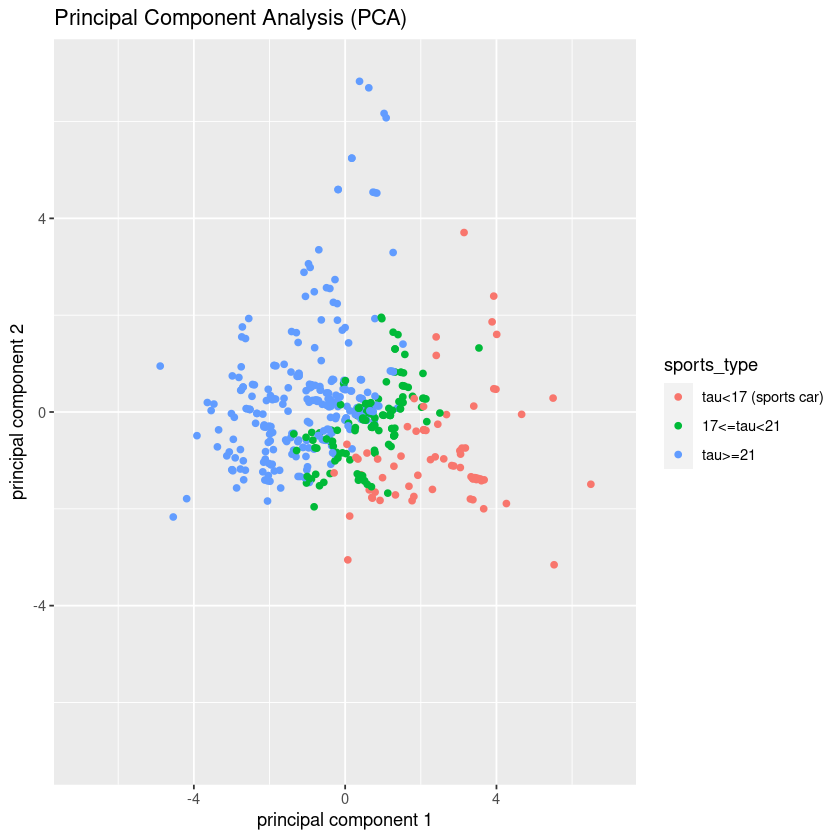

In [236]:
ggplot(sportsCar, aes(x = v1, y = v2, colour = sports_type)) + geom_point() +
  coord_cartesian(xlim = c(-axis_limit, axis_limit), 
                  ylim = c(-axis_limit, axis_limit)) +
  labs(y = paste0("principal component ", pca[2]),
       x = paste0("principal component ", pca[1]),
       title = "Principal Component Analysis (PCA)")

Importantly, the figure above provides a dimension reduction from $R^q=R^5$ to $R^2$ because each car is represented by a point $y_i = (v_1, v_2)$.

This is the core topic of this tutorial which is going to be discussed in more detail below.

### 4.1.2 PCA with `princomp(...)` function

The principal component analysis can also be performed using the `princomp(...)` function in R.

In [237]:
# PCA with package PCA
pcaX <- princomp(as.matrix(X), cor = TRUE)

The summary of a `princomp` object shows the singular values and its contribution to the variance explained.

In [238]:
summary(pcaX)

Importance of components:
                          Comp.1    Comp.2     Comp.3    Comp.4      Comp.5
Standard deviation     1.7221233 1.2881142 0.52653074 0.2971918 0.097444561
Proportion of Variance 0.5931417 0.3318477 0.05544692 0.0176646 0.001899088
Cumulative Proportion  0.5931417 0.9249894 0.98043632 0.9981009 1.000000000

Next, we show the cars represented by the five principal components coordinates.

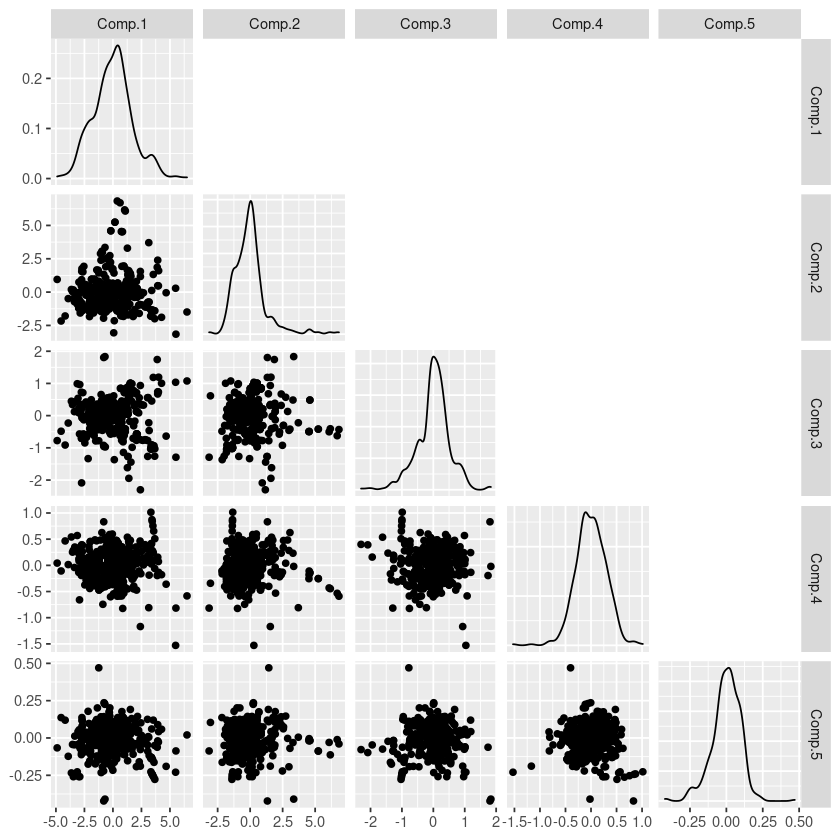

In [239]:
# scatter plot
switch_sign <- -1           # switch sign of the first component to make svd and princomp compatible
dat_pca <- pcaX$scores
dat_pca[, 1] <- switch_sign * dat_pca[, 1]

ggpairs(data.frame(dat_pca), upper = NULL)

Or subsequently, by showing histograms on the diagonal and density plot on the upper right:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



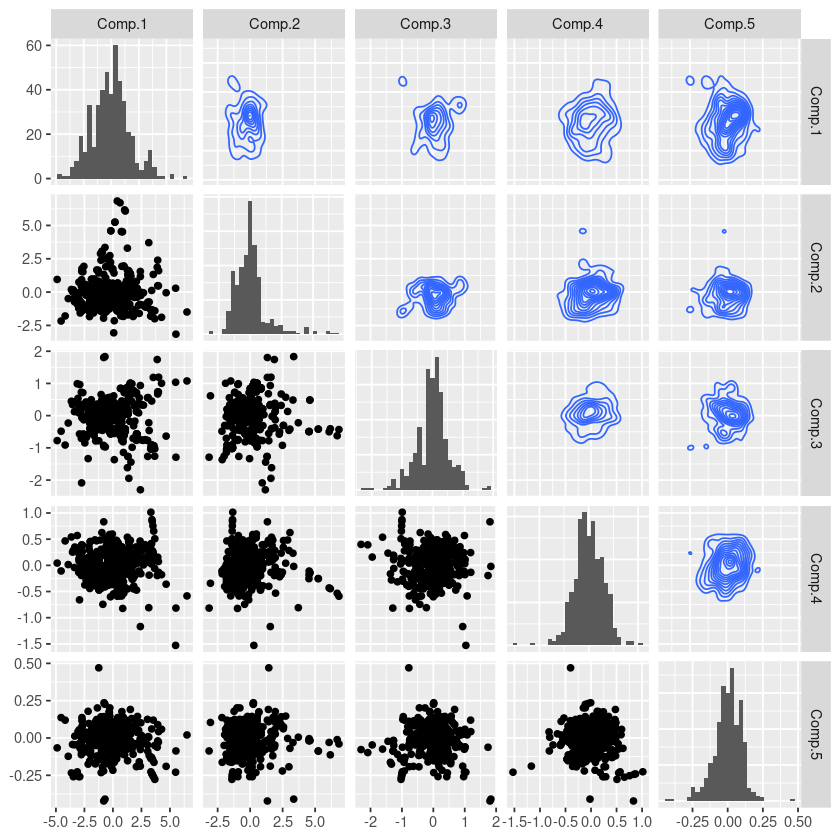

In [240]:
ggpairs(data.frame(dat_pca), diag = list(continuous = "barDiag"),
        upper = list(continuous = "density", combo = "box_no_facet"))

Let us plot the first two principal components again, by using the results from `princomp(...)`, and it coincides with the results from above using `svd(...)`.

In [241]:
# first two dimensions of PCA
pca <- c(1, 2)
sportsCar$p1 <- pcaX$scores[, pca[1]] * switch_sign
sportsCar$p2 <- pcaX$scores[, pca[2]]

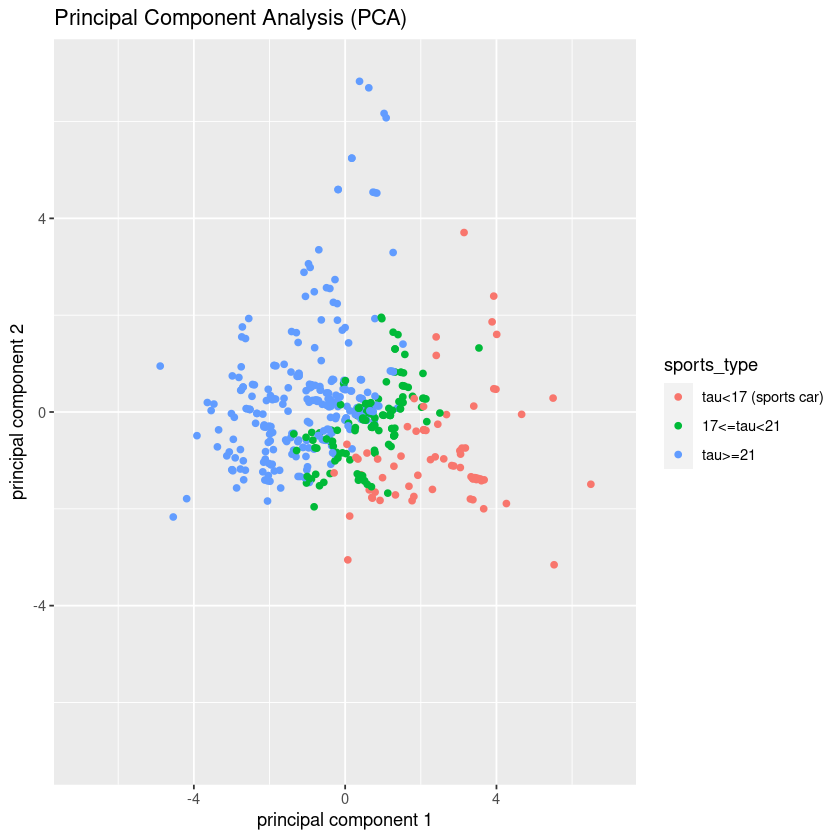

In [242]:
ggplot(sportsCar, aes(x = p1, y = p2, colour = sports_type)) + geom_point() +
    coord_cartesian(xlim = c(-axis_limit, axis_limit),
                    ylim = c(-axis_limit, axis_limit)) +
    labs(y = paste0("principal component ", pca[2]), 
         x = paste0("principal component ", pca[1]),
         title = "Principal Component Analysis (PCA)")

### 4.1.3 Biplot

Finally, below we provide a biplot, which simultaneously shows the first two principal component values  $y_i = (v_1, v_2)$ (on the primary axis) and the two dimensional loading plot illustrating the vectors $(v_{1,l}, v_{2,l}$ for $l = 1,...,q = 5$ (on
the secondary axis).

The low dimensional representations $y_i$ of the cases $i = 1,...,n$ are illustrated by black dots in the figure below, and proximity between black dots means that the corresponding cars are similar. The loading vectors $(v_{1,l}, v_{2,l}$, $l= 1,...,q$, are illustrated by red vectors. Note that these are the components of the first two orthonormal weight vectors $v1$ and $v2$.

The lengths of these red vectors reflect standard deviations along the variables, and the cosines of the angles between the red vectors give the corresponding correlations. The projections of the cases $y_i$ on the axes of the loading vectors $(v_{1,l}, v_{2,l}$ approximate the original cases $x_i$. In fact, this is exact for $q = 2$ and an approximation for $q > 2$, for more interpretation we refer to the literature provided in the paper.

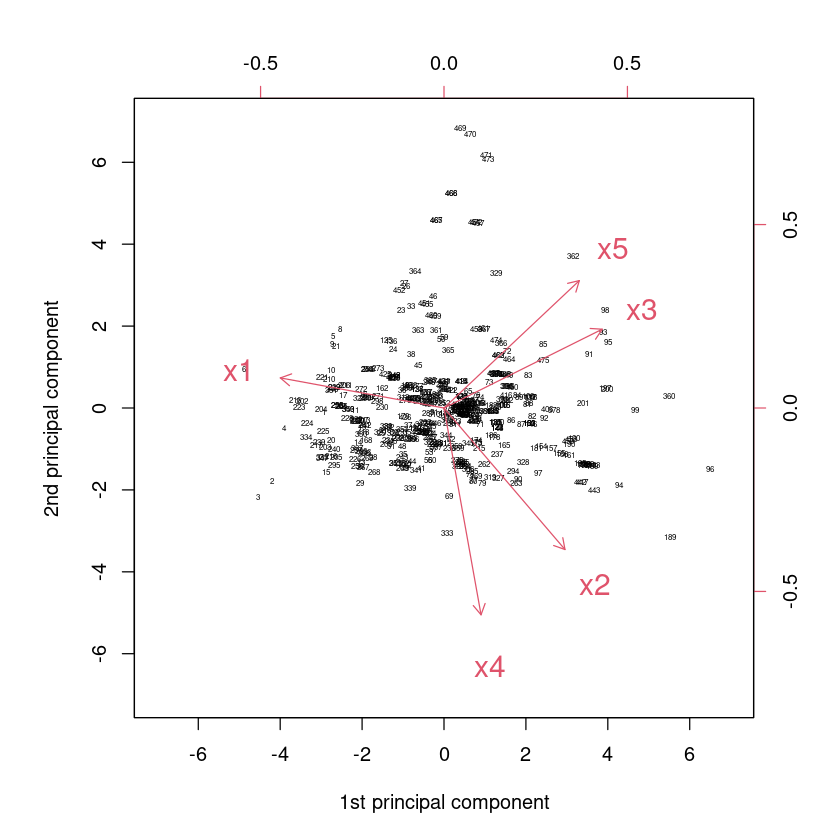

In [243]:
# biplot (unforunately no ggplot2 function available on CRAN)
dat_pca <- pcaX
dat_pca$scores[, 1] <-  switch_sign * dat_pca$scores[, 1]
dat_pca$loadings[1:5, 1] <- switch_sign * dat_pca$loadings[1:5, 1]
biplot(dat_pca, choices = c(1, 2), scale = 0, expand = 2,
  xlab = "1st principal component", ylab = "2nd principal component",
  cex = c(0.4, 1.5), ylim = c(-7, 7), xlim = c(-7, 7)
)


### 4.1.4 Reconstruction error of PCA

The mapping from $R^q$ to $R^2$ is a dimension reduction and hence it is associated with loss of information. Below we show the so called reconstruction error between the original data and the reduced data. Based on the PCA in $p=1,..,5$ dimensions, the original data can be reconstructed (to a certain extend).

This figures give an indication how much information is lost and how many dimensions should be kept in case of further analysis of the data.

See page 15 in the tutorial for more details on the reconstruction error.

In [244]:
recon_pca <- array(NA, c(5))

for (p in 1:5) {
  Xp <- svdX$v[, 1:p] %*% t(svdX$v[, 1:p]) %*% t(X)
  Xp <- t(Xp)
  recon_pca[p] <- sqrt(sum(as.matrix((X - Xp) ^ 2)) / nrow(X))
}
round(recon_pca, 4)

[1] 1.4263 0.6124 0.3128 0.0974 0.0000

In [245]:
# For p = 2 principal components we receive a reconstruction error of 0.6124, which is used below
recon_error <- recon_pca[2]
print(recon_error)

[1] 0.6124157


## 4.2 Bottleneck neural network (BNN)<a name="bnn"></a>

The PCA introduced above can be seen as an autoencoder (see section 3.1 in the paper for the mathematical formulation). In this section we provide a bottleneck neural network (BNN) which is a second example of an autoencoder.

For an introduction to autoencoders and BNN as an example, we recommend to first read chapter 3 of the paper or to have it open together with this notebook.

As an example of a non-linear autoencoder we consider a bottleneck neural network (BNN). BNNs are a special type of feed-forward neural networks. For a general discussion of feed-forward neural networks we refer to the tutorial as well as to the corresponding literature.

## 4.2.1 BNN architecture

To successfully calibrate a BNN it should have an odd number d of hidden layers (d is called the depth of the neural network). The central hidden layer should be low dimensional and all remaining hidden layers should be symmetric around this central hidden layer. The output dimension should be equal to the input dimension, i.e. $q=5$. Thus, for a BNN of depth $d = 3$ we choose the following numbers of neurons: $(q_0,q_1,q_2, q_3, q_4) = (5,7,2,7,5)$.

Such a BNN with  $(q_0,q_1,q_2, q_3, q_4) = (5,7,2,7,5)$, input $x \in R^5$ and output $\in R^5$ (both in blue color), and the black circles are the hidden neurons.

![usl](Figure2_USL.PNG)

The three parameters to be defined are as follows:

In [246]:
# bottleneck architecture
q0 <- ncol(X)
q1 <- 7
q2 <- 2

## 4.2.2 Fitting the model

The code for fitting the model using the `keras` library is given in the helper function `BottleneckThreeLayer(...)` above.

#### Definition and Compilation

In [247]:
# fitting the full model
model3 <- BottleneckThreeLayer(q0, q1, q2)
summary(model3)

Model: "model_4"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  [(None, 5)]                     0           
________________________________________________________________________________
Layer1 (Dense)                      (None, 7)                       35          
________________________________________________________________________________
Bottleneck (Dense)                  (None, 2)                       14          
________________________________________________________________________________
Layer3 (Dense)                      (None, 7)                       14          
________________________________________________________________________________
Output (Dense)                      (None, 5)                       35          
Total params: 98
Trainable params: 98
Non-trainable params: 0
______________________________

#### Fitting

In [248]:
# set hyperparameters
epochs <- 10000
batch_size <- nrow(X)
verbose <- 1

In [249]:
# calibrate full bottleneck network
# expected run-time on Renku 8GB environment around 85 seconds
system.time(
  fit <- model3 %>% fit(as.matrix(X), as.matrix(X), epochs = epochs,
    batch_size = batch_size, verbose = verbose
  )
)

   user  system elapsed 
 50.033   2.538  43.931 

`geom_smooth()` using formula 'y ~ x'



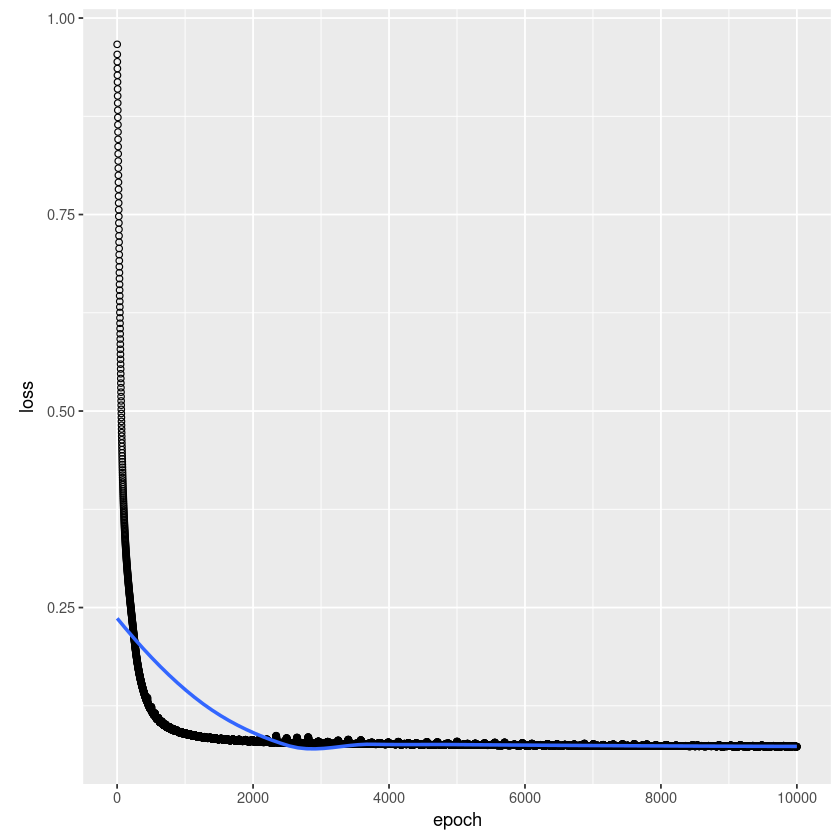

In [250]:
plot(fit)

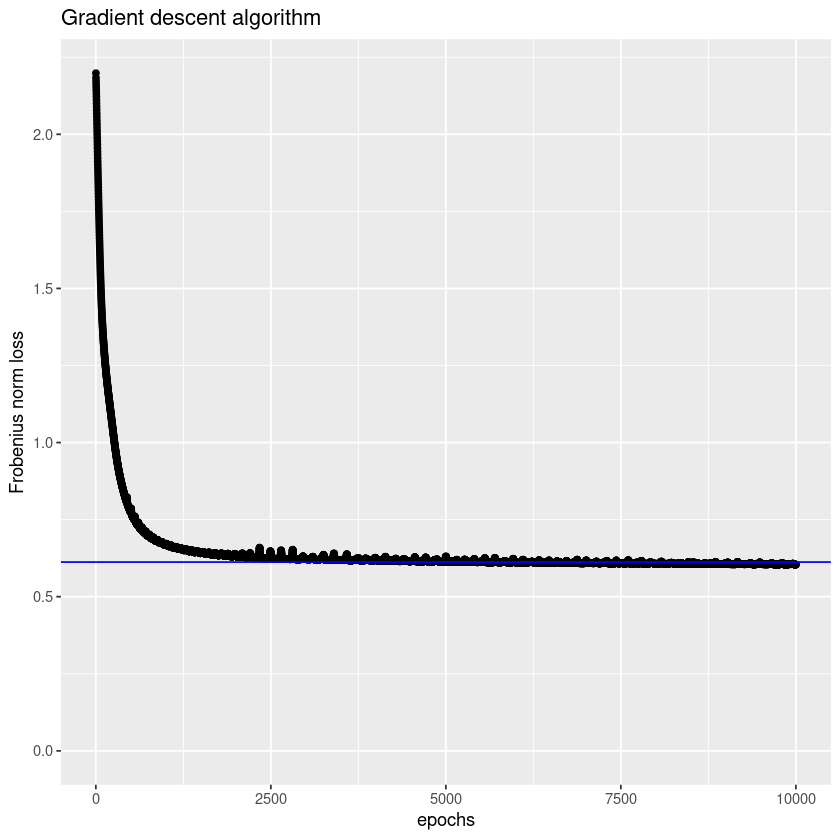

In [251]:
# plot of Frobenius norm loss rather than optimization loss
dat_out <- data.frame(x = c(1:length(fit[[2]]$loss)), y = sqrt(fit[[2]]$loss * q0))
ggplot(dat_out, aes(x = x, y = y)) + geom_point() + 
  geom_hline(yintercept = recon_error, colour = "blue") +
  labs(x = 'epochs', y = 'Frobenius norm loss',
       title = "Gradient descent algorithm") +
  ylim(0, max(sqrt(fit[[2]]$loss * q0)))

#### Evaluation

In [252]:
# reconstruction error (slightly differs from 0.5611 because of missing seed)
fit0 <- model3 %>% predict(as.matrix(X))
round(FrobeniusLoss(X, fit0), 4)

[1] 0.6042

In [253]:
# read off the bottleneck activations
encoder <- keras_model(inputs = model3$input,
                       outputs = get_layer(model3, 'Bottleneck')$output)
y <- encoder %>% predict(as.matrix(X))
ax_limit <- max(abs(y)) * 1.1

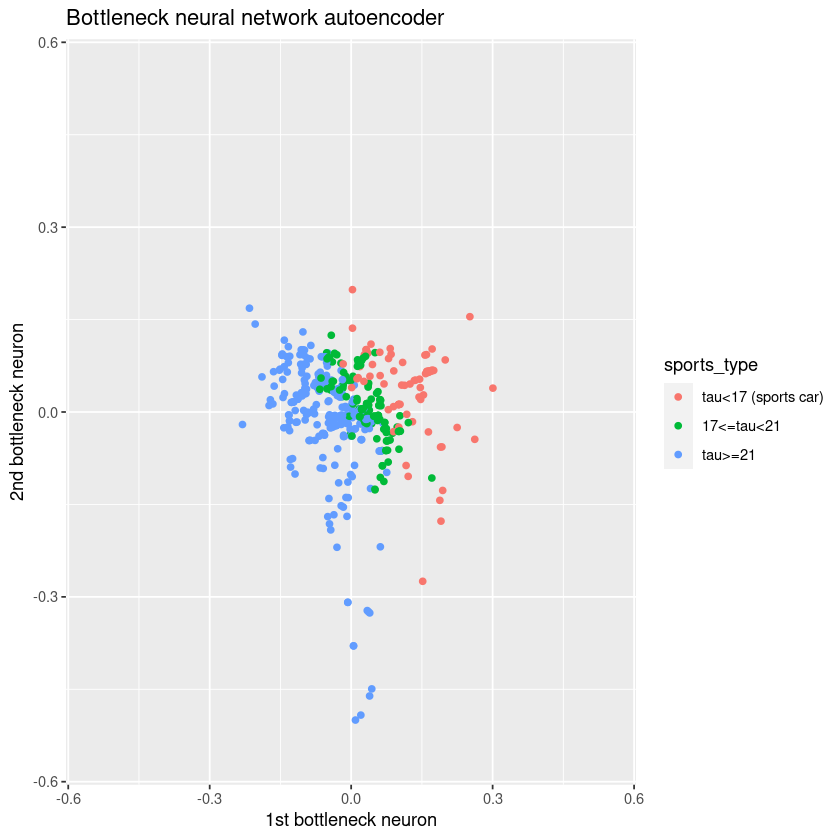

In [254]:
ggplot(data.frame(x = y[, 1], y = y[, 2], sports_type = sportsCar$sports_type), aes(x = x, y = y, color = sports_type)) + 
  geom_point() +
  coord_cartesian(xlim=c(-ax_limit, ax_limit),ylim=c(-ax_limit, ax_limit)) +
  labs(y = "2nd bottleneck neuron", x = "1st bottleneck neuron",
       title = "Bottleneck neural network autoencoder")

This BNN has been trained brute force by applying the gradient descent algorithm. In this problem this worked well because it is a low dimensional problem. However, in high dimensional situations it often does not work properly. Therefore, a pre-training approach needs to be used, see the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3439358), p. 18ff.

# 5. Clustering<a name="clustering"></a>

## 5.1 Introduction<a name="introClustering"></a>

The previous methods have aimed at reducing the dimension of the data by projecting the feature space to a lower dimensional space such that the original data can be reconstructed sufficiently well. These projections have led to continuous low dimensional representations $\mathcal{Y} \subset R^p$ of the data $\mathcal{X} \subset R^q$. In the present section we do not focus on having good reconstruction properties, but we rather aim at partitioning the data $\mathcal{X}$ into $K$ clusters such that the resulting clusters are homogeneous. The latter is measured using again a dissimilarity measure which we try to minimize simultaneously on all clusters.

There are different types of clustering methods. One distinguishes between (i) hierarchical clustering, (ii) centroid-based clustering and (iii) distribution-based clustering. There are two types of hierarchical clusterings. The bottom-up clustering algorithm merges recursively similar clusters to bigger clusters until, eventually, the algorithm is stopped. That is, this algorithm groups clusters tree-like into a next higher level. A top-down clustering algorithm acts differently in that it splits recursively (and tree-like) the entire portfolio into smaller (more homogeneous) sub-groups. We will not study hierarchical clustering methods in this tutorial.

Centroid-based and distribution-based clustering methods need to pre-specify the number of clusters wanted. We describe these two types of clustering methods in the following sections. In the whole section, we will look at different clustering methods and visualize the clusters in the 2-dimensional space spanned by the first two principal component.

Below, we calculate (again for completeness) the PCA and add the coordinates to the original dataset. This is the same as in section 4.1 above.

In [255]:
sportsCar <- sportsCar %>% dplyr::select(-c(p1,p2,v1,v2))

In [256]:
# normalization of design matrix (using 1/n for sd, identical figures to slides)
X01 <- dat - colMeans(dat)[col(dat)]
X <- X01 / sqrt(colMeans(X01 ^ 2))[col(X01)]

# singular value decomposition / PCA
SVD <- svd(as.matrix(X))

# all dimensions of PCA
pca <- c(1,2,3,4,5)
sportsCar <- sportsCar %>% mutate(
  v1 = as.matrix(X) %*% SVD$v[, pca[1]],
  v2 = as.matrix(X) %*% SVD$v[, pca[2]],
  v3 = as.matrix(X) %*% SVD$v[, pca[3]],
  v4 = as.matrix(X) %*% SVD$v[, pca[4]],
  v5 = as.matrix(X) %*% SVD$v[, pca[5]])

## 5.1 $K$-means clustering<a name="kmeans"></a>

$K$-means clustering is a centroid-based clustering that partitions the $n$ cases $x_i \in R^q$ into $K$ disjoint clusters based on a hyperparameter $K$.

As the initial cluster centers are randomly chosen, a seed needs to be set to ensure reproducibility.

In [257]:
# set seed
set.seed(seed)

### 5.1.1 Select number of clusters

The number of clusters $K$ is a hyperparameter that needs to be selected. For every number of clusters $k=1,...,K$ the objective function is calculated and compared between the number of cluster.
We set a maximum number of 10 clusters to be considered (exercise: look at more and justify why 10 is reasonable in this case).

In [258]:
# initialize for hyperparameter search
k_max <- 10       # maximum number of clusters to be considered

We use a for loop to calculate the $k$-means clustering for every $k=1,...,K$.

In [259]:
# define objects for loop over K clusters
k_average <- colMeans(X)  # average columns
Centers <- list()
TWCD <- array(NA, c(k_max))  # Total Within-Cluster Dissimilarity (TWCD)
Classifier <- array(1, c(k_max, nrow(X)))
TWCD[1] <- sum(colSums(as.matrix(X ^ 2)))

In [260]:
# run K-means algorithm for 1:k_max clusters
for (cl in 2:k_max) {
  if (cl == 2) {
    (kmeansX <- kmeans(X, cl))
  }
  if (cl > 2) {
    (kmeansX  <- kmeans(X, cluster_centers))
  }
  TWCD[cl] <- sum(kmeansX$withins)
  Classifier[cl, ] <- kmeansX$cluster
  Centers[[cl]] <- kmeansX$centers
  cluster_centers <- array(NA, c(cl + 1, ncol(X)))
  cluster_centers[cl + 1, ] <- k_average
  cluster_centers[1:cl, ] <- kmeansX$centers
}

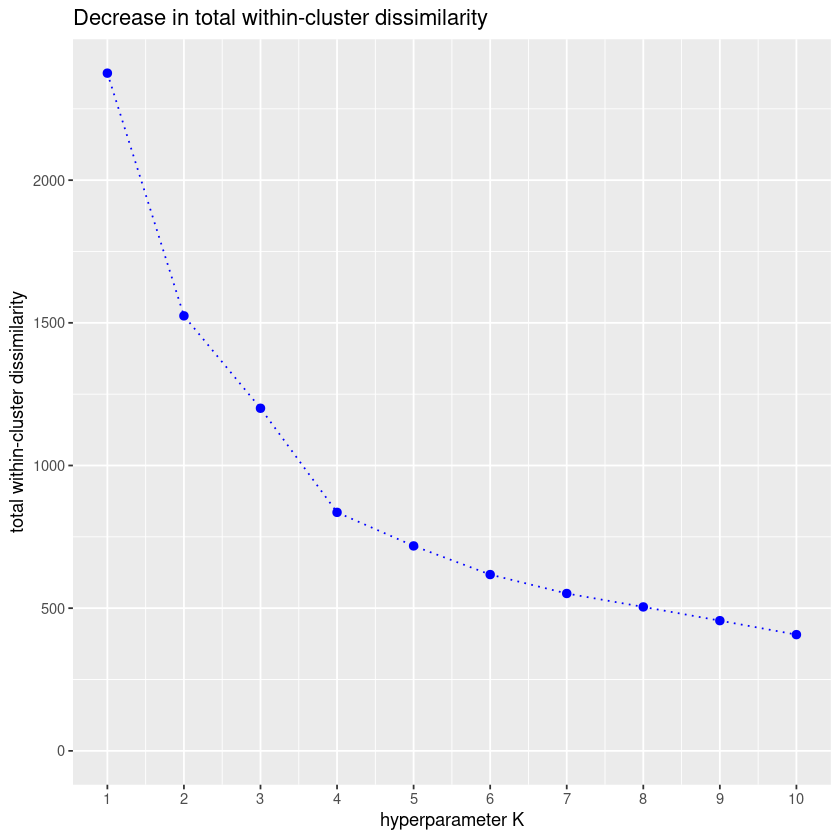

In [261]:
# plot objective function
ggplot(tibble(x = c(1:k_max), y = TWCD), aes(x = x, y = y)) + 
  geom_point(size = 2, colour = "blue") + 
  geom_line(linetype = 3, colour = "blue") +
  labs(x = "hyperparameter K", y = "total within-cluster dissimilarity", 
       title ="Decrease in total within-cluster dissimilarity") +
  coord_cartesian(ylim = c(0, max(TWCD))) +
  scale_x_continuous(breaks = 1:k_max)

Using the elbow method (see for example [Wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering))), the optimal number of clusters seems to be 4.

In [262]:
# select optimal number of clusters
nr_cluster <- 4

### 5.1.2 Characteristics of clusters 

Let us look at certain statistics for the number of selected clusters. One statistic to examine is the number of points in each cluster.

In [263]:
# number of points per cluster
table(Classifier[nr_cluster, ])


  1   2   3   4 
145  59  33 238 

The table below summarizes the $K$-means clustering results w.r.t. sports cars (expert judgment) for $K = 4$. Interestingly, most of the sports cars belong to cluster 2 and a couple of sports cars fall into cluster 4 (which contains roughly 50% of all cars). Thus, cluster 2 could be called the "sports car cluster", and cluster 4 may need further analysis.

In [264]:
# number of sports cars per cluster
sportsCar <- sportsCar %>% add_column(mean_cluster=factor(Classifier[nr_cluster, ]))

out <- sportsCar %>% group_by(mean_cluster,sports_type) %>% summarize(COUNT=n())
out

`summarise()` has grouped output by 'mean_cluster'. You can override using the `.groups` argument.



mean_cluster,sports_type,COUNT
<fct>,<fct>,<int>
1,17<=tau<21,13
1,tau>=21,132
2,tau<17 (sports car),50
2,17<=tau<21,9
3,tau<17 (sports car),1
3,17<=tau<21,4
3,tau>=21,28
4,tau<17 (sports car),21
4,17<=tau<21,105


In [265]:
# centers of clusters
Centers[[nr_cluster]]

,x1,x2,x3,x4,x5
1,1.0132552,-0.6508214,-1.1205886,-0.08721436,-1.051081
2,-1.7000782,1.6397489,1.5336677,0.64181410,1.035187
3,0.1986199,-1.4360191,1.0312075,-2.50092988,1.469640
4,-0.2234111,0.1891284,0.1595341,0.24079721,0.179969


In practice, one should perform further analysis and investigations to ensure that the clusters make sense from an actuarial/business perspective.

Based on these figures, it might be still challenging to achieve a good understanding of the clusters. Hence, we visualize the clustering using the dimension reduction techniques introduced in the previous chapter.

### 5.1.3 Clusters on principal component axes

The graph below illustrates the four clusters on the first two principal component axes obtained from the PCA. In black we show the four cluster centers.

In [266]:
# cluster centers coordinates in first two principal components coordinates
kk1 <- Centers[[nr_cluster]] %*% SVD$v[, pca[1]]
print(kk1)
kk2 <- Centers[[nr_cluster]] %*% SVD$v[, pca[2]]
print(kk2)

        [,1]
1 -1.9330135
2  3.0090190
3  0.2150727
4  0.4019220
        [,1]
1 -0.2779906
2 -0.5560393
3  3.3897735
4 -0.1628049


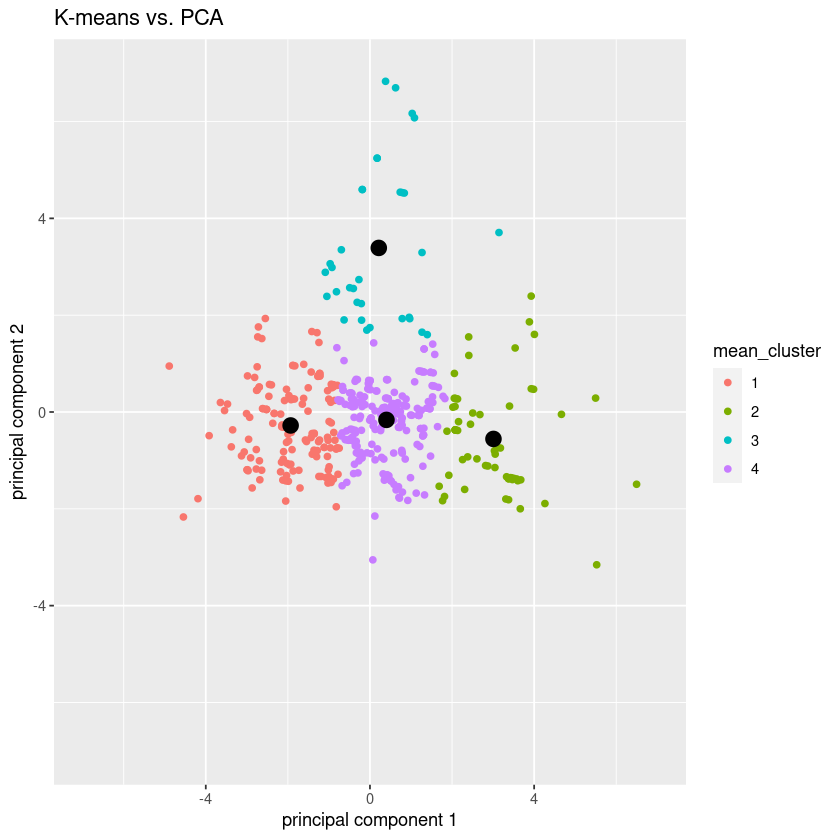

In [267]:
ggplot(sportsCar, aes(x = v1, y = v2, colour = mean_cluster)) + geom_point() +
  coord_cartesian(xlim = c(-axis_limit, axis_limit),
                  ylim = c(-axis_limit, axis_limit)) +
  labs(y = paste("principal component ", pca[2], sep = ""),
       x = paste("principal component ", pca[1], sep = ""),
       title = "K-means vs. PCA"
  )  +
  geom_point(data = tibble(x = kk1, y = kk2),
             aes(x = x, y = y),
             size = 4,
             colour = "black"
  )

Remarkable is that in 4-means clustering we obtain sharp color borders w.r.t. the first two principal components of the PCA. This expresses that 4-means clustering essentially uses the first two principal components for clustering.

This is further supported by the next figure which shows the clusters w.r.t. the last two principal components.

In [268]:
kk4 <- Centers[[nr_cluster]] %*% SVD$v[, pca[4]]
print(kk4)
kk5 <- Centers[[nr_cluster]] %*% SVD$v[, pca[5]]
print(kk5)

         [,1]
1 -0.03874828
2  0.06408218
3 -0.01808223
4  0.01022842
         [,1]
1  0.01637366
2  0.04985155
3  0.01681002
4 -0.02466451


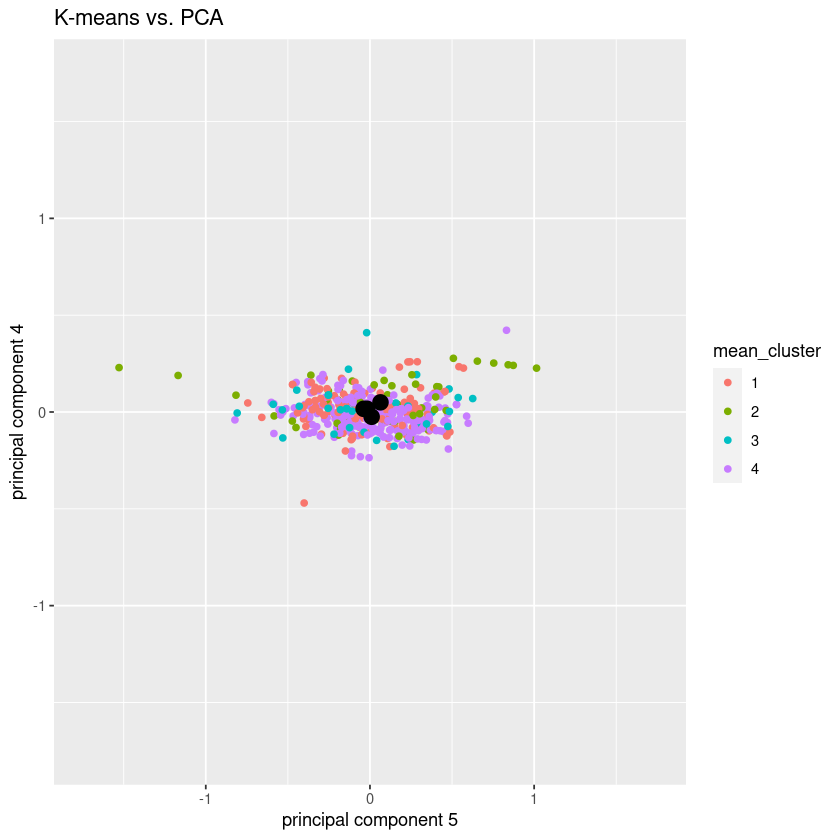

In [269]:
ggplot(sportsCar, aes(x = v4, y = v5, colour = mean_cluster)) + geom_point() +
  coord_cartesian(xlim = c(-axis_limit / 4, axis_limit / 4),
                  ylim = c(-axis_limit / 4, axis_limit / 4)) +
  labs(y = paste("principal component ", pca[4], sep = ""),
       x = paste("principal component ", pca[5], sep = ""),
       title = "K-means vs. PCA"
  ) +
  geom_point(data = tibble(x = kk4, y = kk5),
             aes(x = x, y = y),
             size = 4,
             colour = "black"
  )

## 5.2 $K$-medoids clustering<a name="kmedoids"></a>

$K$-medoids clustering is a centroid-based method that is closely related to $K$-means clustering. The main difference between these two methods is that the $K$-medoids clustering uses explicit data points $x_i$ as cluster centers, whereas the cluster centers of the $K$-means clustering typically do not belong to the observed data points $X$. Moreover, the $K$-medoids clustering may consider dissimilarity measures different from squared Euclidean distances. The $K$-medoids method is more robust than the $K$-means clustering if we choose dissimilarity measures that can deal with outliers, for instance, an absolute value distance gives less weight to outliers than a squared Euclidean distance. The resulting cluster centers are called medoids because they are located most centrally within the cluster.

### 5.2.1 Fit $K$-medoids

As the initial cluster centers are randomly chosen, a seed needs to be set to ensure reproducibility.

In [270]:
# set parameters
set.seed(seed)

We choose here the number of clusters as selected by the $k$-means algorithm.

In [271]:
# set parameters
nr_cluster <- 4 # number of clusters

In [272]:
# run k-medoids algorithm
pamX <- pam(X, k = nr_cluster, metric = "manhattan", diss = FALSE)

### 5.2.2 Characteristics of clusters

In [273]:
# number of points in every cluster
table(pamX$clustering)


  1   2   3   4 
142  39 215  79 

The table below summarizes the $K$-medoids clustering results w.r.t. sports cars (expert judgment) for $K = 4$. The same conclusions hold as in the previous section.

In [274]:
# number of sports cars per cluster
sportsCar <- sportsCar %>% add_column(med_cluster=factor(pamX$clustering))

out <- sportsCar %>% group_by(med_cluster,sports_type) %>% summarize(COUNT=n())
out

`summarise()` has grouped output by 'med_cluster'. You can override using the `.groups` argument.



med_cluster,sports_type,COUNT
<fct>,<fct>,<int>
1,17<=tau<21,14
1,tau>=21,128
2,tau<17 (sports car),1
2,17<=tau<21,4
2,tau>=21,34
3,tau<17 (sports car),18
3,17<=tau<21,89
3,tau>=21,108
4,tau<17 (sports car),53


The advantage of the $k$-medoids clustering algorithm is that the centers are data points in the data, and should be further examined and validated from an actuarial perspective.

In [275]:
# medoids in original data
sportsCar[pamX$id.med,]

,brand,type,model,cubic_capacity,max_power,max_torque,seats,weight,max_engine_speed,seconds_to_100,⋯,x3,x4,x5,v1,v2,v3,v4,v5,mean_cluster,med_cluster
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>,<fct>
242,Ford,Escort,2 generation [Facelift],1298,44,92,5,885,5500,16.7,⋯,4.521789,8.612503,7.168580,-1.9172711,-0.4226336,0.15355362,0.04207401,-0.01974065,1,1
455,Ford,Taurus,1 generation,2496,77,190,5,1414,4400,10.9,⋯,5.247024,8.389360,7.822445,-0.4044125,2.5511465,-0.30895798,0.34468052,-0.06143720,3,2
388,Ford,Scorpio,1 generation,1993,85,160,5,1200,5500,10.6,⋯,5.075174,8.612503,7.597396,0.4535939,-0.1537612,-0.00650405,0.11875932,-0.13212134,4,3
92,BMW,Serie5,5281,2788,135,240,5,1300,5800,8.4,⋯,5.480639,8.665613,7.933080,2.4490827,-0.2524913,0.33562998,-0.16056037,-0.10165100,2,4


In [276]:
# Medoid points in covariates
pamX$medoids

x1,x2,x3,x4,x5
1.0715297,-0.6562626,-1.1441365,0.1634453,-0.9826837
0.7545162,-1.0702621,0.5651967,-2.0184099,0.8841668
-0.1612451,0.3524799,0.1601568,0.1634453,0.2416307
-1.4936540,0.9100785,1.1158118,0.6827431,1.2000411


### 5.2.3 Clusters on principal component axes

The graph below illustrates the four clusters on the first two principal component axes obtained from the PCA. In black we show the four cluster centers.

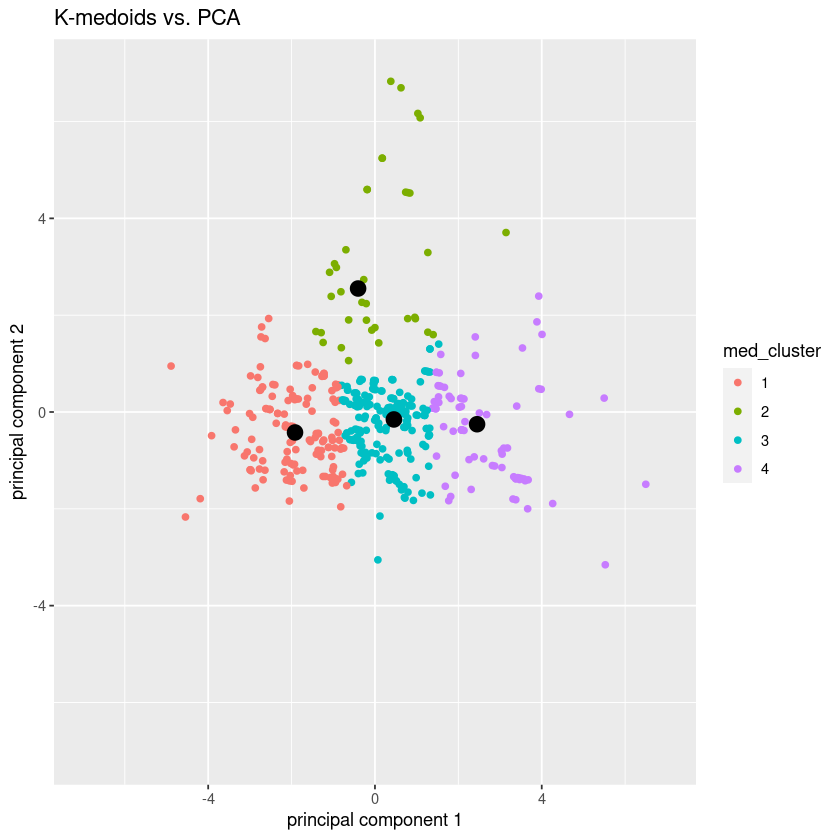

In [277]:
ggplot(sportsCar, aes(x = v1, y = v2, colour = med_cluster)) + geom_point() +
  coord_cartesian(xlim = c(-axis_limit, axis_limit),
                  ylim = c(-axis_limit, axis_limit)) +
  labs(y = paste("principal component ", pca[2], sep = ""),
       x = paste("principal component ", pca[1], sep = ""),
       title = "K-medoids vs. PCA") +
  geom_point(data = sportsCar[pamX$id.med, ],
             aes(x = v1, y = v2),
             size = 4,
             colour = "black")

## 5.3 Gaussian mixture models (GMM)<a name="gmm"></a>

The $K$-means algorithm is based on the implicit assumption that dissimilarity is roundish. Gaussian mixture models (GMMs) are distribution-based clustering methods that provide more flexibility with respect to this assumption.

Observe that all methods studied above have not been based on any assumptions on how the features $x_i \in \mathcal{X}$ could have been generated. In this section we underpin a probabilistic model on how these features could have been generated.

### 5.3.1 Fit GMM (only diagonal covariance matrices!)

As the initial cluster centers are randomly chosen, a seed needs to be set to ensure reproducibility.

In [278]:
# set seed
set.seed(seed)

We choose here the number of clusters as selected by the $K$-means algorithm.

In [279]:
# set parameters
nr_cluster <- 4 # number of clusters

In [280]:
# run GMM algorithm
gmmX <-GMM(X, gaussian_comps = nr_cluster, dist_mode = "eucl_dist", 
           seed_mode = "random_subset", em_iter = 5, seed = seed)

summary(gmmX)

                    Length Class  Mode   
centroids             20   -none- numeric
covariance_matrices   20   -none- numeric
weights                4   -none- numeric
Log_likelihood      1900   -none- numeric

### 5.3.2 Characteristics of clusters

In [281]:
# number of points in every cluster
gmm_cluster <- factor(predict_GMM(X, gmmX$centroids, 
                                  gmmX$covariance_matrices, 
                                  gmmX$weights)$cluster_labels)
table(gmm_cluster)

gmm_cluster
  0   1   2   3 
 86  40 149 200 

The table below summarizes the GMM clustering results w.r.t. sports cars (expert judgment) for $K=4$. The same conclusions hold as in the previous section.

In [282]:
# number of sports cars per cluster
sportsCar <- sportsCar %>% add_column(gmm_cluster=gmm_cluster)

out <- sportsCar %>% group_by(gmm_cluster,sports_type) %>% summarize(COUNT=n())
out

`summarise()` has grouped output by 'gmm_cluster'. You can override using the `.groups` argument.



gmm_cluster,sports_type,COUNT
<fct>,<fct>,<int>
0,tau<17 (sports car),55
0,17<=tau<21,25
0,tau>=21,6
1,tau<17 (sports car),2
1,17<=tau<21,7
1,tau>=21,31
2,tau<17 (sports car),1
2,17<=tau<21,15
2,tau>=21,133


In [283]:
# centroids
gmmX$centroids

-1.46391650,1.2896932,1.30795408,0.65680397,0.96878516
0.07414484,-1.0647011,1.03212130,-2.08217734,1.34307220
0.99089692,-0.6252102,-1.11054957,-0.05784064,-1.04159984
-0.16978970,0.1818901,0.08243945,0.22932131,0.09655388


### 5.3.3 Clusters on principal component axes

The graph below illustrates the four clusters on the first two principal component axes obtained from the PCA. In black we show the four cluster centers.

In [284]:
kk1 <- gmmX$centroids %*% SVD$v[, pca[1]]
print(kk1)

           [,1]
[1,]  2.5826319
[2,]  0.4325412
[3,] -1.8964965
[4,]  0.2875696


In [285]:
kk2 <- gmmX$centroids %*% SVD$v[, pca[2]]
print(kk2)

           [,1]
[1,] -0.4630200
[2,]  2.8482176
[3,] -0.3065174
[4,] -0.2026414


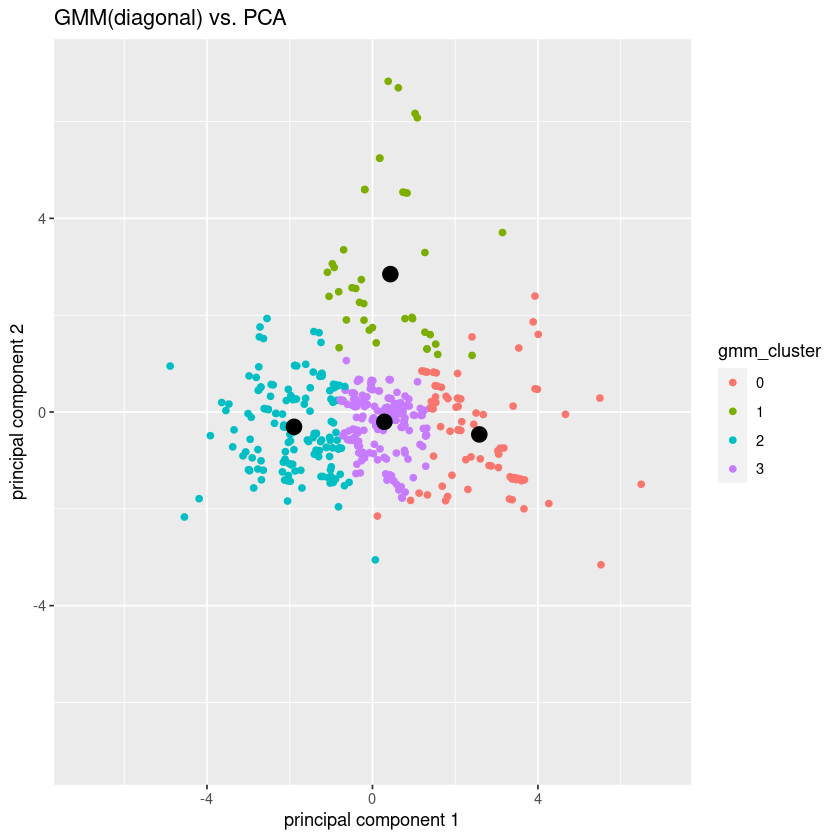

In [286]:
ggplot(sportsCar, aes(x = v1, y = v2, colour = gmm_cluster)) + geom_point() +
  coord_cartesian(xlim = c(-axis_limit, axis_limit), 
                  ylim = c(-axis_limit, axis_limit)) +
  labs(y = paste("principal component ", pca[2], sep = ""),
       x = paste("principal component ", pca[1], sep = ""),
       title = "GMM(diagonal) vs. PCA"
  ) +
  geom_point(data = tibble(x = kk1, y = kk2), aes(x = x, y = y),
             size = 4, colour = "black")

# 6. Low dimensional visualizations<a name="vis"></a>

## 6.1 Introduction<a name="introLdv"></a>

So far, we have been discussing two different types of methods. The first type of methods (PCA and BNNs) has been used to reduce the dimension of the data. The main objective in this dimension reduction has been to minimize the reconstruction error of the original data. The second type of methods ($K$-means, $K$-medoids and GMMs) has been aiming at categorizing data into clusters of similar cases. The methods that we are going to study in the remainder of this tutorial mainly aim at visualizing high dimensional data. This is also done by dimension reduction, but the main objective in this section is to keep the (local) topology of the data as far as possible. This is motivated by the idea that if $\mathcal{X}$ is a lower dimensional manifold in $R^q$, then it can be described by lower dimensional object preserving the local topological relationships.

The input for the low dimensional visualizations techniques is the scaled design matrix $X$. (Although already done in previous section, we do it here again for being able to simply run this part).

In [287]:
# normalization of design matrix (using 1/n for sd, identical figures to slides)
X01 <- dat - colMeans(dat)[col(dat)]
X <- X01 / sqrt(colMeans(X01 ^ 2))[col(X01)]

## 6.2 t-distributed stochastic neighboring embedding (t-SNE)<a name="tsne"></a>

The idea behind t-SNE is to study proximity weights between all available features $x_1,...,x_n$. Dissimilar cases will receive small weights, and similar cases will attain high weights. Based on these weights we will construct a low dimensional t-distribution which has a small KL divergence w.r.t. these proximity weights. This t-distribution then leads us to the low dimensional illustration of the original data.

This algorithm needs a seed and correspondingly the solution will depend on the choice of this seed.

In [288]:
# set parameters
set.seed(seed)

t-SNE contains several hyperparameters (which can be tuned), see the help file of `tsne(...)` for further details and the tutorial.

In [289]:
emb_dim <- 2   # set the dimension of the resulting embedding.
perp <- 30     # Perplexity parameter. (optimal number of neighbors)

t-SNE can be fit using the function `tsne(...)` of the `tsne` package. We choose a $p = 2$ dimensional illustration, and we minimize the KL divergence using the gradient descent algorithm. This algorithm needs a seed and correspondingly the solution will depend on the choice of this seed.

In [290]:
# expected run-time on 8GB environment around 100 seconds
# KL divergence 0.428360613444932
system.time(
  tsneX <- tsne(X, k = emb_dim, initial_dim = ncol(X), perplexity = perp)
)

Warning message in if (class(X) == "dist") {:
“the condition has length > 1 and only the first element will be used”
sigma summary: Min. : 0.345466813670024 |1st Qu. : 0.447029405944972 |Median : 0.491571975669631 |Mean : 0.511790863304395 |3rd Qu. : 0.554012469885358 |Max. : 0.932264556538405 |

Epoch: Iteration #100 error is: 14.0446281283442

Epoch: Iteration #200 error is: 0.496280092835798

Epoch: Iteration #300 error is: 0.455084009433219

Epoch: Iteration #400 error is: 0.44734610359205

Epoch: Iteration #500 error is: 0.446242130157629

Epoch: Iteration #600 error is: 0.445918208567879

Epoch: Iteration #700 error is: 0.445787538502579

Epoch: Iteration #800 error is: 0.445728035354052

Epoch: Iteration #900 error is: 0.445698310251141

Epoch: Iteration #1000 error is: 0.44568282498934



   user  system elapsed 
 58.426   0.303  58.738 

The output of t-SNE are coordinates in the emb_dim space. By default, we have selected emb_dim=2 which allows us to correctly visualize the t-SNE result in two dimensions.

We observe that the solutions differ for different seeds, however, they have quite some similarities (exercise: try out different random seeds!).

Let us visualize the result in the 2-dimensional space.

In [291]:
# 2-dimensional visualization parameters (even if emb_dim>2)
i1 <- 2     # x-axis dimension
i2 <- 1     # y-axis dimension
sign0 <- 1  # scaling (if helpful)

In [292]:
# 2 dimensional coordinates
tsneX1 <- tsneX[, c(i1, i2)]
tsneX1 <- sign0 * tsneX1
tsneX1 <- data.frame(tsneX1)
colnames(tsneX1) <- c("x_tsne", "y_tsne")

# add to raw data
sportsCar <- sportsCar %>% add_column(tsneX1)

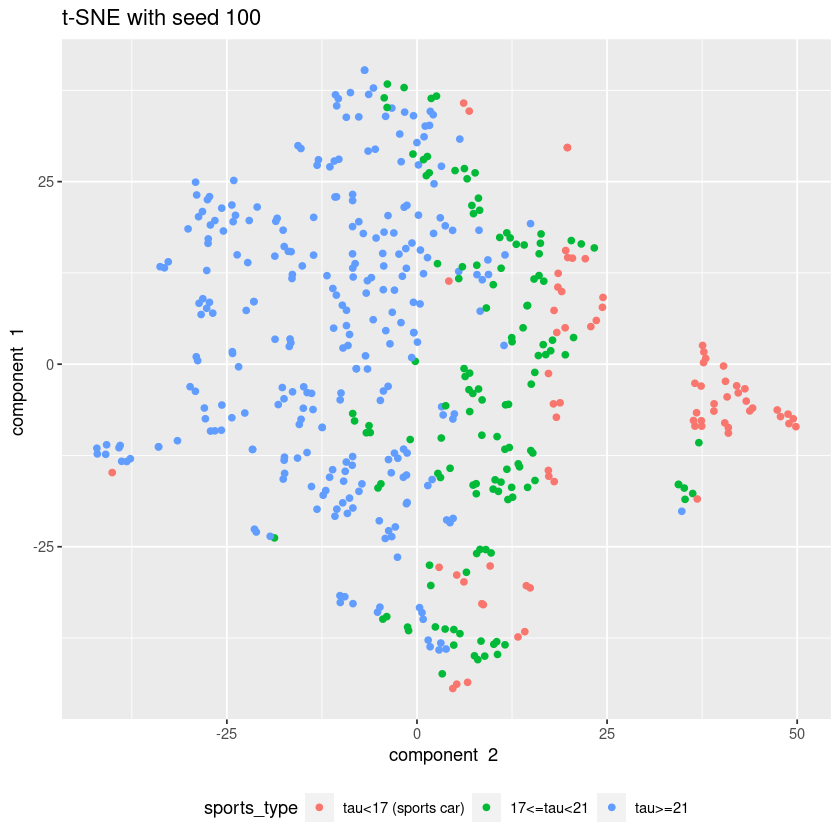

In [293]:
ggplot(sportsCar, aes(x = x_tsne, y = y_tsne, colour = sports_type)) + geom_point() + 
  theme(legend.position = "bottom") +
  labs(x = paste("component ", i1, paste = ""),
       y = paste("component ", i2, paste = ""),
       title = list(paste("t-SNE with seed ", seed, sep = "")))

With t-SNE, we have now a emb_dim-dimensional representation of the data, derived from the $q=5$-dim space before. If there are much more covariates, the dimension reduction is very powerful.

If we interpret the results in the above chart w.r.t. sports cars we see that there are rather clear cases of sports cars, and cases which are less obvious. In some sense this is similar to the findings in $K$-means clustering.

## 6.3 Uniform manifold approximation and projection (UMAP)<a name="umap"></a>

Uniform manifold approximation and projection (UMAP) is a manifold learning technique for dimension reduction. It is based on Riemannian geometry and algebraic topology.
UMAP is based on the assumption that the data $\mathcal{X} \subset R^q$ is lying on a lower dimensional manifold, and it aims at learning the local structure to find the lower dimensional representation. The basic learning structure of the algorithm is similar to t-SNE.

This algorithm needs a seed and correspondingly the solution will depend on the choice of this seed.

In [294]:
# set parameters
set.seed(seed)

UMAP contains several hyperparameters (which can be tuned), see the help file of `umap(...)` for further details and the tutorial. `umap(...)` is contained in the `umap` package.

In [295]:
k_neighbors <- 15     # number of nearest neighbors, default 15
min_dist <- 0.1       # determines how close points appear in the final layout
n_comp <- 2           # dimension of target (output) space

# set umap input parameters
umap_param <- umap.defaults
umap_param$n_components <- n_comp
umap_param$n_neighbors <- k_neighbors
umap_param$random_state <- seed
umap_param$min_dist <- min_dist 

In [296]:
# UMAP
# expected run-time on 8GB environment around 2 seconds
system.time(
  umapX <- umap(X, config = umap_param, method = "naive")
)

   user  system elapsed 
  1.067   0.000   1.068 

Let us visualize the result in the 2-dimensional space.

In [297]:
# 2-dimensional visualization parameters (even if n_comp>2)
i1 <- 2
i2 <- 1
sign0 <- 1 # scaling (if helpful)

In [298]:
# 2 dimensional coordinates
umapX1 <- umapX$layout[, c(i1, i2)]
umapX1 <- sign0 * umapX1
umapX1 <- data.frame(umapX1)
colnames(umapX1) <- c("x_umap", "y_umap")

# add to raw data
sportsCar <- sportsCar %>% add_column(umapX1)

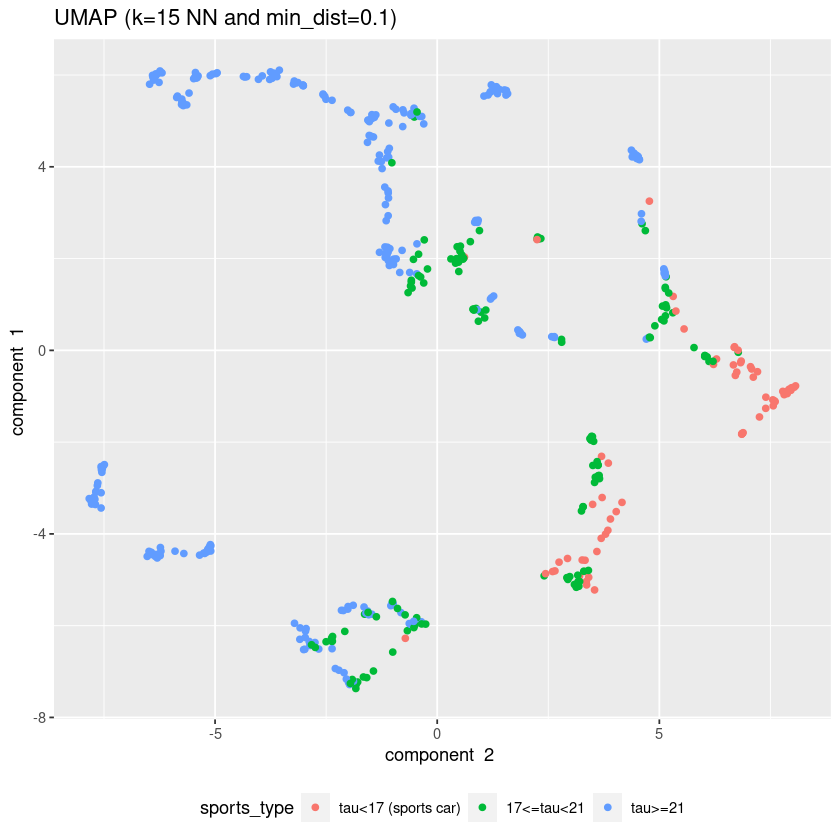

In [299]:
ggplot(sportsCar, aes(x = x_umap, y = y_umap, colour = sports_type)) + geom_point() +
  theme(legend.position = "bottom") + 
  labs(x = paste("component ", i1, paste = ""),
       y = paste("component ", i2, paste = ""),
       title = paste("UMAP (k=", k_neighbors,
                     " NN and min_dist=", min_dist, ")", sep = "")
  )

# 6.4 Self-organizing map and Kohonen map (SOM)<a name="som"></a>

Self-organizing maps (SOM) is another dimension reduction technique that allows us to illustrate high dimensional cases in low dimensional spaces preserving part of the original topology. The method goes back to Kohonen, and for this reason it is also called Kohonen map.

This algorithm needs a seed and correspondingly the solution will depend on the choice of this seed.

In [300]:
# set parameters
set.seed(seed)

SOM can be fit using the function `som(...)` of the `kohonen` package. We choose $J = 10$, in $R^2$ and the squared Euclidean distance in $R^q$.

In [301]:
n1 <- 2       # x dimensions of the grid
n2 <- 10      # x dimensions of the grid
rlen <- 100   # the number of times the complete data set will be presented to the network.

In [302]:
# expected run-time on 8GB environment just fractions of a second
system.time(
  somX <- som(as.matrix(X), 
              grid = somgrid(xdim = n1, ydim = n2, topo = "rectangular"),
              rlen = rlen, dist.fcts = "sumofsquares"
          )
)

   user  system elapsed 
  0.026   0.000   0.026 

In [303]:
summary(somX)

SOM of size 2x10 with a rectangular topology and a bubble neighbourhood function.
The number of data layers is 1.
Distance measure(s) used: sumofsquares.
Training data included: 475 objects.
Mean distance to the closest unit in the map: 0.551.


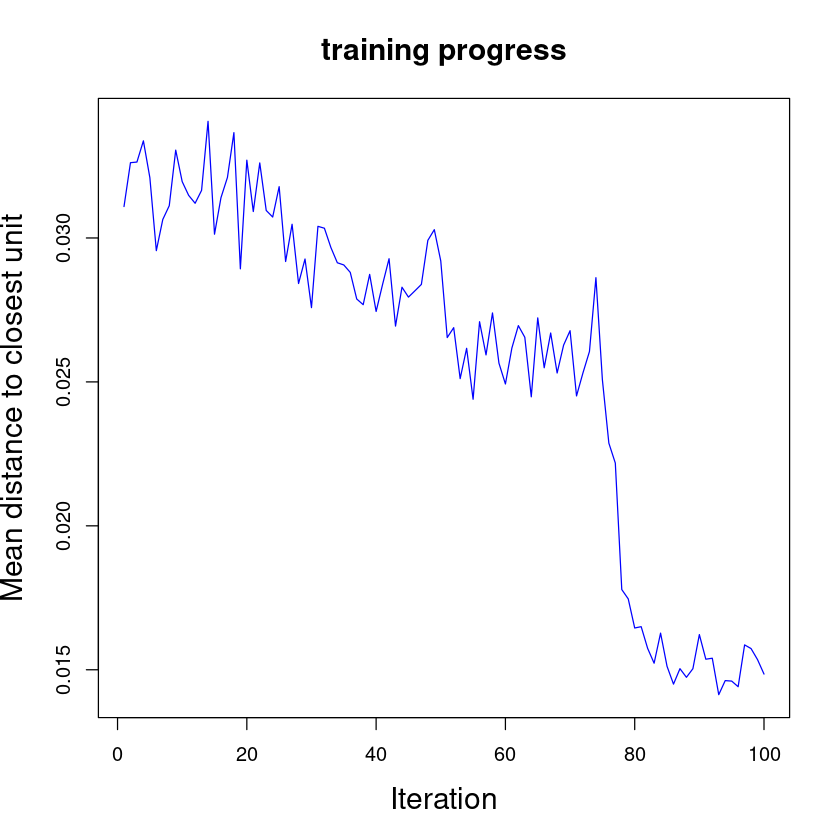

In [304]:
# plot.kohonen is built on basic R graphics, not ggplot
plot(somX, c("changes"), main = list("training progress", cex = 1.5),
     col = "blue", cex.lab = 1.5
)            # training progress

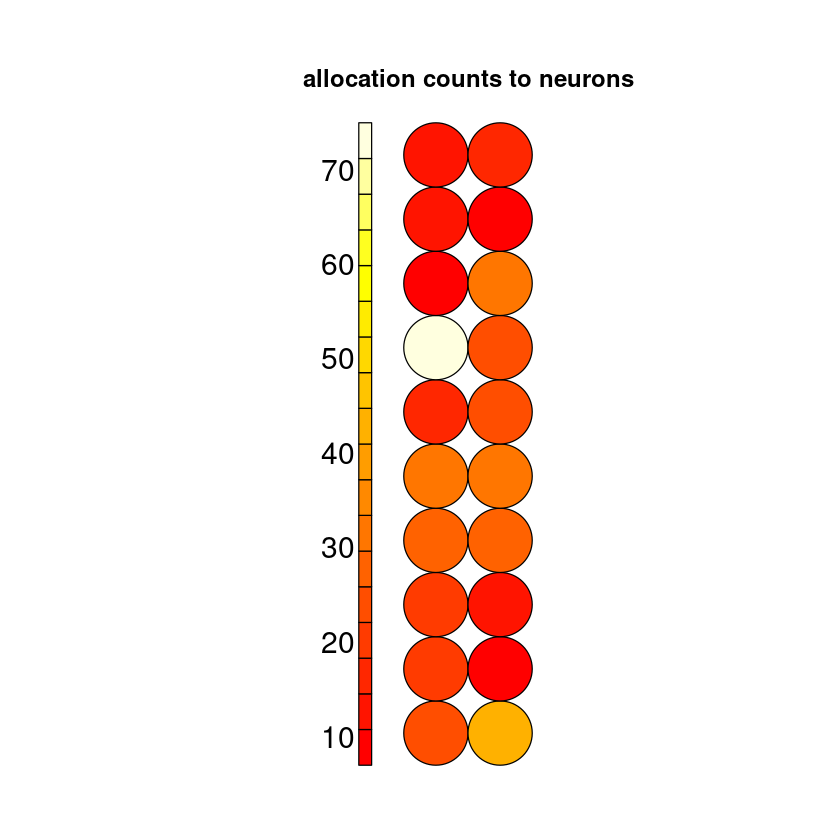

In [305]:
plot(somX, c("counts"), main = "allocation counts to neurons", cex.lab = 1.5)

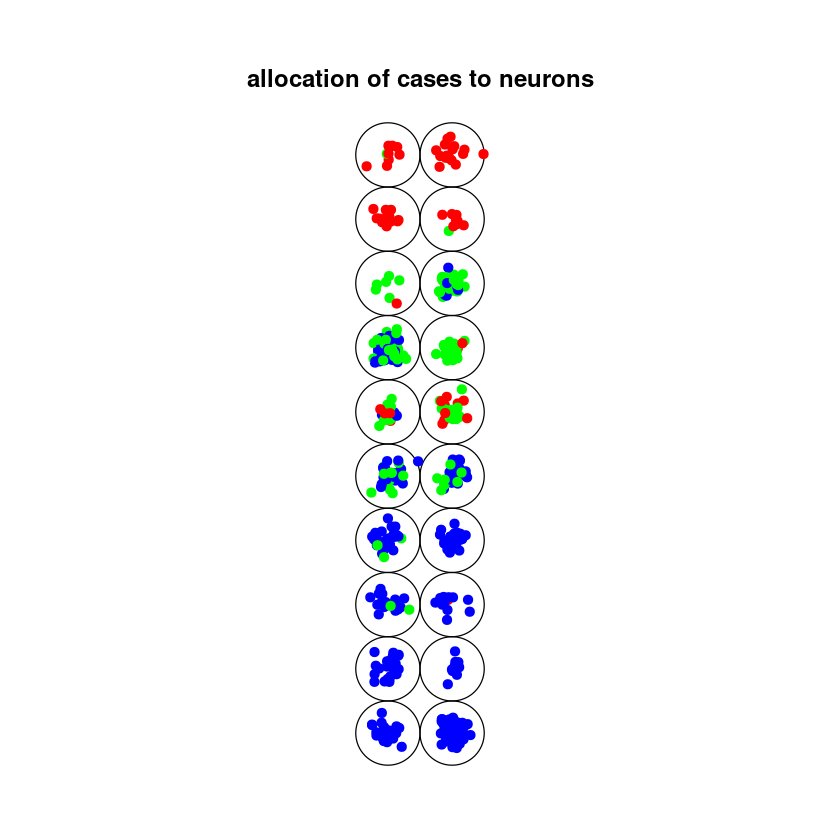

In [306]:
sportsCar <- sportsCar %>% mutate(tau2=sports_car + as.integer(tau < 21) + 1)

plot(somX, c("mapping"), classif = predict(somX),
     col = c("blue", "green", "red")[sportsCar$tau2], pch = 19,
     main = "allocation of cases to neurons")

If we consider the last Kohonen map, we are tempted to define the sports cars to be those cars whose BMNs are in the upper two rows of that map. Most of the dots that are allocated to these neurons have a red color, which implies (bottom line) that the judgment of the Kohonen map is quite similar to the Belgium expert choice. On the other hand, the example also shows that there are quite some similarities between the different neurons, for this reason one should explore the individual neurons in more detail before making conclusions.

# 7. Remarks<a name="rmk"></a>

In the following we mention aspects which might be relevant in other applications.

**Categorical variables**
- We have focused on the continuous variables. The treatment of categorical variables is more difficult
because they do not offer a canonical distance function.
- All feature components chosen above are continuous (or at least ordered), and
therefore they are well-suited for Euclidean distances, Manhattan distances, Gaussian kernels,
etc. The treatment of nominal categorical variables is more difficult, i.e. how can we measure
distances, for instance, between car brands, models or colors?
- See chapter 6 of the paper for further discussions on the treatment of categorical features.
- A metric used in practice is the Gower distance, which defines a distance function for numerical and categorical features. See `?daisy` in the `cluster` package for details and references.
- One can also think about replacing categorical levels by numerical figures, e.g.
    - country/region/area --> latitude/longitude
    - zip code --> latitude/longitude
    - number of observations per level, or transformations thereof

**Combining low-dimensional visualizations and clustering**
- In applications it might be beneficial to combine clustering and low-dimensional visualizations. One can first calculate a low-dimensional representation and then apply clustering.

**Understanding clusters**
- In applications it is often necessary to understand and characterize clusters from a business/actuarial perspective.
- There are no mathematical methods for that, one needs to find "good" representative of the clusters and characterize the cluster by the kind of variables in the cluster.

# 8. Session Info<a name="session"></a>

The html is generated with the follow packages (which migth be slightly newer than the ones used in the published tutorial).

In [307]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] reticulate_1.18    gridExtra_2.3      GGally_2.1.0       keras_2.3.0.0     
 [5] MASS_7.3-53.1      kohonen_3.0.10     umap_0.2.7.0       tsne_0.1-3        
 [9] ClusterR_1.2.2     gtools_3.8.2       cluster_2.1.1      matrixStats_0.57.0
[13] plotrix_3.7-8      f

In [308]:
# Checking package versions
packageVersion('keras')               # version keras 2.3.0.0
packageVersion('tensorflow')          # version tensorflow 2.2.0 (TensorFlow backend > 2.0 and Python 3.7)

[1] ‘2.3.0.0’

[1] ‘2.2.0’

In [309]:
reticulate::py_config()

python:         /usr/bin/python3
libpython:      /usr/lib/python3.8/config-3.8-x86_64-linux-gnu/libpython3.8.so
pythonhome:     //usr://usr
version:        3.8.5 (default, Jan 27 2021, 15:41:15)  [GCC 9.3.0]
numpy:          /usr/local/lib/python3.8/dist-packages/numpy
numpy_version:  1.20.1
tensorflow:     /usr/local/lib/python3.8/dist-packages/tensorflow

python versions found: 
 /usr/bin/python3
 /usr/bin/python

In [310]:
tensorflow::tf_version()

[1] ‘2.4’